In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0825dataset(sleep).csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry", "EMA_T_Diff",'bored','How_stressed','How_tired',
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))

/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_61318/111915411.py:17: DtypeWarning: Columns (101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.6871
Precision    0.1395
Recall       0.4236
F1           0.2097
ROC AUC      0.6425
PR AUC       0.1449
dtype: float64

🔍 평균 Feature Importance (Top 15):
              Feature  Importance
52          Intensity    0.202159
18  mean_intensity_1h    0.128669
13             hungry    0.104310
12           Time_24h    0.051596
48       Z_Previous_4    0.033941
45     2_2.5h_pre_std    0.030458
39     1_1.5h_pre_std    0.025804
42     1.5_2h_pre_std    0.024588
16       How_stressed    0.022613
17          How_tired    0.022112
30          TimeInBed    0.020305
14         EMA_T_Diff    0.016512
32         Sleep_Diff    0.016334
2        15m_G_Diff_7    0.015241
50        Z_Intensity    0.014588


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

# ===== 0) 설정 =====
FEATURES = X_columns                # 이미 정의됨
LABEL_COL = "GE_1h"                 # 현재 라벨 이름
GROUP_COL = "StudyID"
TS_COL = "Timestamp"                # df에 존재하는 타임스탬프 컬럼명

# ===== 1) df_model 정리: y_true 생성 =====
df_model_oof = df_model.copy()
if "y_true" not in df_model_oof.columns:
    df_model_oof["y_true"] = df_model_oof[LABEL_COL].astype(int)

# ===== 2) 메타정보(ts/date/hour_float) 복구 =====
ts_series = pd.to_datetime(df.loc[df_model_oof.index, TS_COL], errors="coerce")
meta = pd.DataFrame({
    "StudyID": df_model_oof[GROUP_COL].values,
    "ts": ts_series.values,
    "date": ts_series.dt.date.values,
    "hour_float": (ts_series.dt.hour + ts_series.dt.minute/60.0).values,
    "y_true": df_model_oof["y_true"].values
}).dropna(subset=["ts"])

# ===== 3) OOF 확률 계산 (GroupKFold + SMOTE 각 fold마다 적용) =====
X_all = df_model_oof[FEATURES].to_numpy()
y_all = df_model_oof["y_true"].to_numpy()
groups = df_model_oof[GROUP_COL].to_numpy()

oof_prob = np.zeros(len(df_model_oof), dtype=float)
oof_true = np.zeros(len(df_model_oof), dtype=int)

gkf = GroupKFold(n_splits=5)

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_all, y_all, groups)):
    X_tr, y_tr = X_all[tr_idx], y_all[tr_idx]
    X_va, y_va = X_all[va_idx], y_all[va_idx]

    # SMOTE (fold 내부에서만)
    cnt1 = np.bincount(y_tr)[1] if 1 in np.unique(y_tr) else 0
    if cnt1 > 1:
        k_neighbors = min(5, cnt1 - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

    model_fold = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model_fold.fit(X_tr, y_tr)
    prob_va = model_fold.predict_proba(X_va)[:, 1]

    oof_prob[va_idx] = prob_va
    oof_true[va_idx] = y_va

    print(f"Fold {fold+1} ROC-AUC: {roc_auc_score(y_va, prob_va):.3f}")

print(f"OOF ROC-AUC (all): {roc_auc_score(oof_true, oof_prob):.3f}")

# ===== 4) pred_df_oof 생성 (정책 함수가 요구하는 칼럼들 포함) =====
pred_df_oof = meta.copy()
pred_df_oof["y_prob"] = oof_prob

need_cols = {"StudyID","ts","date","hour_float","y_true","y_prob"}
missing = need_cols - set(pred_df_oof.columns)
assert not missing, f"pred_df_oof missing columns: {missing}"

# ===== 5) 정책 적용 =====
def summarize_alerts_table(alerts_df: pd.DataFrame):
    if alerts_df is None or alerts_df.empty:
        print("No alerts after policy.")
        empty = pd.DataFrame(columns=["StudyID","UniqueDays","TotalAlerts","Alerts_per_day_mean","Alerts_per_day_median"])
        return empty, np.nan

    per_pid_day = alerts_df.groupby(["StudyID","date"]).size().reset_index(name="alerts")
    per_pid = (per_pid_day.groupby("StudyID")["alerts"]
               .agg(UniqueDays="count", TotalAlerts="sum",
                    Alerts_per_day_mean="mean", Alerts_per_day_median="median")
               .reset_index())

    success_rate = float(alerts_df["success"].mean())

    print("\n=== Policy-level alert summary (TABLE) ===")
    print(f"Total alerts: {len(alerts_df)}")
    print(f"Overall success rate: {success_rate:.3f}")
    print(f"Median alerts/day across participants: {per_pid['Alerts_per_day_median'].median():.2f}")
    print(f"Mean alerts/day across participants: {per_pid['Alerts_per_day_mean'].mean():.2f}")

    return per_pid, success_rate

def generate_alerts_with_policy_fast(
    pdf: pd.DataFrame,
    threshold: float = 0.3,
    min_hour: float = 8.0,
    max_hour: float = 22.0,
    require_two_hits: bool = True,
    two_hit_window_min: int = 30,
    cooldown_min: int = 120,
    per_day_cap: int = 4,
    high_conf_single_hit_prob: float = None
):
    need_cols = ["StudyID","ts","date","y_true","y_prob","hour_float"]
    if not set(need_cols).issubset(pdf.columns):
        raise KeyError(f"pred_df_oof missing {list(set(need_cols)-set(pdf.columns))}")

    d = pdf.loc[(pdf["hour_float"] >= min_hour) & (pdf["hour_float"] <= max_hour), need_cols].copy()
    d["is_pos"] = (d["y_prob"] >= threshold).astype(np.uint8)
    d = d[d["is_pos"] == 1]
    if d.empty:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts = []
    for (pid, day), g in d.sort_values(["StudyID","date","ts"]).groupby(["StudyID","date"]):
        times = g["ts"].to_numpy()
        probs = g["y_prob"].to_numpy(dtype=float)
        yts   = g["y_true"].to_numpy(dtype=int)

        if require_two_hits:
            win = np.timedelta64(two_hit_window_min, "m")
            j_right = np.searchsorted(times, times + win, side="right") - 1
            has_pair = (j_right > np.arange(len(times)))
            has_pair &= (times[j_right] - times) <= win

            if high_conf_single_hit_prob is not None:
                high_conf = probs >= float(high_conf_single_hit_prob)
                cand_mask = has_pair | high_conf
            else:
                cand_mask = has_pair

            if not np.any(cand_mask):
                continue
            cand_idx = np.nonzero(cand_mask)[0]
        else:
            cand_idx = np.arange(len(times))

        selected = []
        if len(cand_idx) > 0:
            cooldown = np.timedelta64(cooldown_min, "m")
            last_alert_time = times[0] - cooldown - np.timedelta64(1, "m")
            # 확률 높은 순으로 선택 (time 우선이면 probs 대신 times로 정렬)
            for i in cand_idx[np.argsort(-probs[cand_idx])]:
                if times[i] - last_alert_time < cooldown:
                    continue
                selected.append(i)
                last_alert_time = times[i]
                if len(selected) >= per_day_cap:
                    break

        if not selected:
            continue
        for i in selected:
            alerts.append({
                "StudyID": pid, "ts": times[i], "date": day,
                "y_true_at_alert": int(yts[i]),
                "y_prob_at_alert": float(probs[i])
            })

    if not alerts:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts_df = pd.DataFrame(alerts)
    alerts_df["success"] = alerts_df["y_true_at_alert"].astype(int)
    return alerts_df

# 너의 S1 정책 그대로
S1 = dict(
    threshold=0.30,
    min_hour=8.0, max_hour=22.0,
    require_two_hits=True,
    two_hit_window_min=45,
    cooldown_min=90,
    per_day_cap=5,
    high_conf_single_hit_prob=0.60
)

alerts_S1 = generate_alerts_with_policy_fast(pred_df_oof, **S1)
per_pid_S1, sr_S1 = summarize_alerts_table(alerts_S1)

tp = int(alerts_S1["success"].sum())
total = len(alerts_S1)
print(f"Event-level: TP={tp}, FP={total - tp}, Total={total} (SR={tp/total:.3f})")


Fold 1 ROC-AUC: 0.656
Fold 2 ROC-AUC: 0.631
Fold 3 ROC-AUC: 0.624
Fold 4 ROC-AUC: 0.638
Fold 5 ROC-AUC: 0.667
OOF ROC-AUC (all): 0.643

=== Policy-level alert summary (TABLE) ===
Total alerts: 692
Overall success rate: 0.140
Median alerts/day across participants: 2.00
Mean alerts/day across participants: 2.09
Event-level: TP=97, FP=595, Total=692 (SR=0.140)


In [7]:

# ===== 6) 120분 성공 재마킹 =====
def mark_success_window(alerts_df: pd.DataFrame, full_df: pd.DataFrame, window_min: int = 120):
    alerts = alerts_df.copy()
    alerts["success_120m"] = 0
    
    # full_df에서 필요한 칼럼만
    full = full_df[["StudyID", "ts", "y_true"]].copy()
    
    for i, row in alerts.iterrows():
        sid = row["StudyID"]
        t0 = row["ts"]
        t1 = t0 + pd.Timedelta(minutes=window_min)
        
        # 같은 참가자에서 alert 이후 window_min 내에 GE 발생 있는지 확인
        mask = (full["StudyID"] == sid) & (full["ts"] > t0) & (full["ts"] <= t1)
        if (full.loc[mask, "y_true"] == 1).any():
            alerts.at[i, "success_120m"] = 1
    
    return alerts

# 실행
alerts_S1_120 = mark_success_window(alerts_S1, pred_df_oof, window_min=120)

# 결과 요약
tp = int(alerts_S1_120["success_120m"].sum())
total = len(alerts_S1_120)
fp = total - tp
sr = tp / total if total > 0 else float("nan")

print(f"\n=== Policy alerts (120m window) ===")
print(f"TP={tp}, FP={fp}, Total={total}, SR={sr:.3f}")



=== Policy alerts (120m window) ===
TP=222, FP=470, Total=692, SR=0.321


# SHAP plot w/ GE model (692) 0904

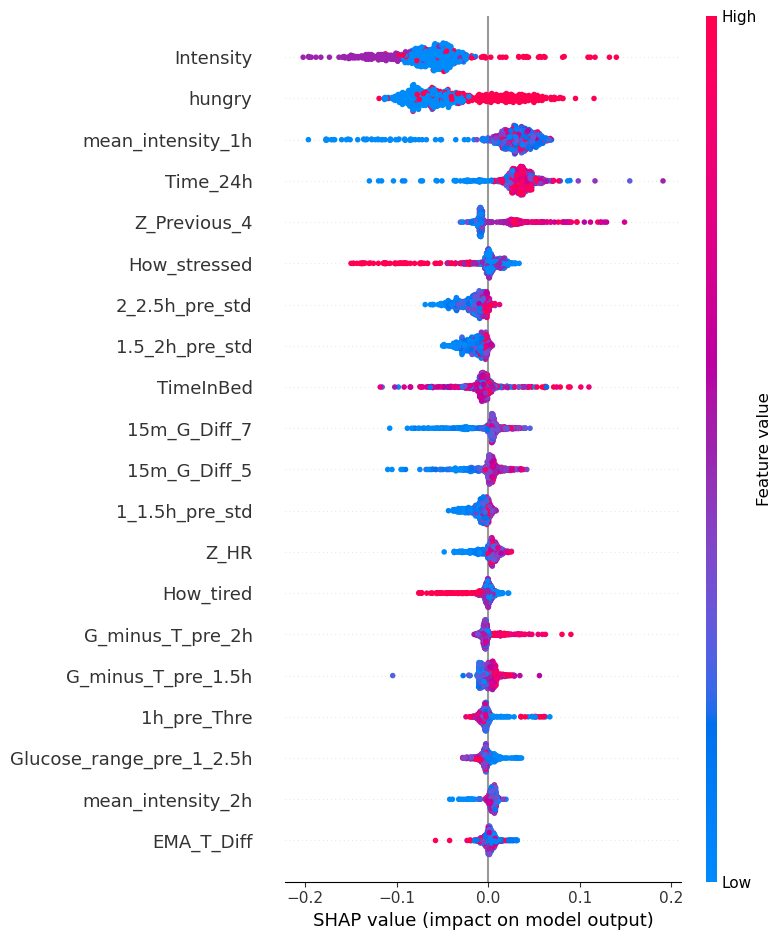

In [11]:
import shap
import matplotlib.pyplot as plt

# 1) Timestamp 형식 맞추기
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
alerts_S1_120["ts"] = pd.to_datetime(alerts_S1_120["ts"], errors="coerce")

# 2) merge 실행
alerts_with_X = alerts_S1_120.merge(
    df[["StudyID", "Timestamp"] + FEATURES],
    left_on=["StudyID", "ts"],
    right_on=["StudyID", "Timestamp"],
    how="left"
)

# 3) X matrix 준비
X_alerts_mod = alerts_with_X[FEATURES].copy()

# 필요 시 binary 변수 → float (예시)
if "hungry" in X_alerts_mod.columns:
    X_alerts_mod["hungry"] = X_alerts_mod["hungry"].astype(float)

# 4) SHAP explainer 생성
# (여기서 'model'은 RandomForestClassifier 같은 학습된 모델 객체여야 함)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_alerts_mod)

# 5) summary plot
shap.summary_plot(
    shap_values[1],           # positive class 기준
    X_alerts_mod,
    feature_names=FEATURES,
    show=True
)
plt.show()


# SHAP value > 0 (+)

In [35]:
import numpy as np
import pandas as pd
import shap

# 1) SHAP 값 계산 (알림 데이터 기준)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_alerts_mod)   # X_alerts_mod: 알림 692개
shap_pos = shap_values[1]   # class=1에 대한 SHAP 값

# 2) 양수 SHAP만 반영
shap_pos_only = np.where(shap_pos > 0, shap_pos, np.nan)

# 3) 지표 계산
positive_rate = pd.Series(
    np.nanmean(shap_pos > 0, axis=0),
    index=FEATURES,
    name="Positive_rate"
)

mean_positive = pd.Series(
    np.nanmean(np.where(shap_pos > 0, shap_pos, np.nan), axis=0),
    index=FEATURES,
    name="Mean_positive_shap"
)

sum_positive = pd.Series(
    np.nansum(np.where(shap_pos > 0, shap_pos, np.nan), axis=0),
    index=FEATURES,
    name="Sum_positive_shap"
)

# 4) 요약 테이블
summary_df = pd.concat([positive_rate, mean_positive, sum_positive], axis=1)
summary_df["Weighted_positive"] = (
    summary_df["Positive_rate"] * summary_df["Mean_positive_shap"]
)

# 5) 정렬 및 출력 (양수 SHAP 총합 기준)
rank_metric = "Sum_positive_shap"
summary_sorted = summary_df.sort_values(
    [rank_metric, "Mean_positive_shap", "Positive_rate"],
    ascending=False
)

print("\n=== Top 15 features by {} (알림 692개, positive only) ===".format(rank_metric))
print(summary_sorted.head(15).round(6))



=== Top 15 features by Sum_positive_shap (알림 692개, positive only) ===
                          Positive_rate  Mean_positive_shap  \
Time_24h                       0.934971            0.036758   
mean_intensity_1h              0.908960            0.033471   
Z_Previous_4                   0.391618            0.035004   
hungry                         0.252890            0.033277   
15m_G_Diff_7                   0.774566            0.008332   
How_stressed                   0.609827            0.008660   
Z_HR                           0.736994            0.006936   
15m_G_Diff_5                   0.674855            0.007437   
mean_intensity_2h              0.927746            0.005365   
TimeInBed                      0.223988            0.015408   
EMA_T_Diff                     0.657514            0.005081   
G_minus_T_pre_1.5h             0.511561            0.006486   
G_minus_T_pre_2h               0.215318            0.015156   
Glucose_range_pre_1_2.5h       0.338150        

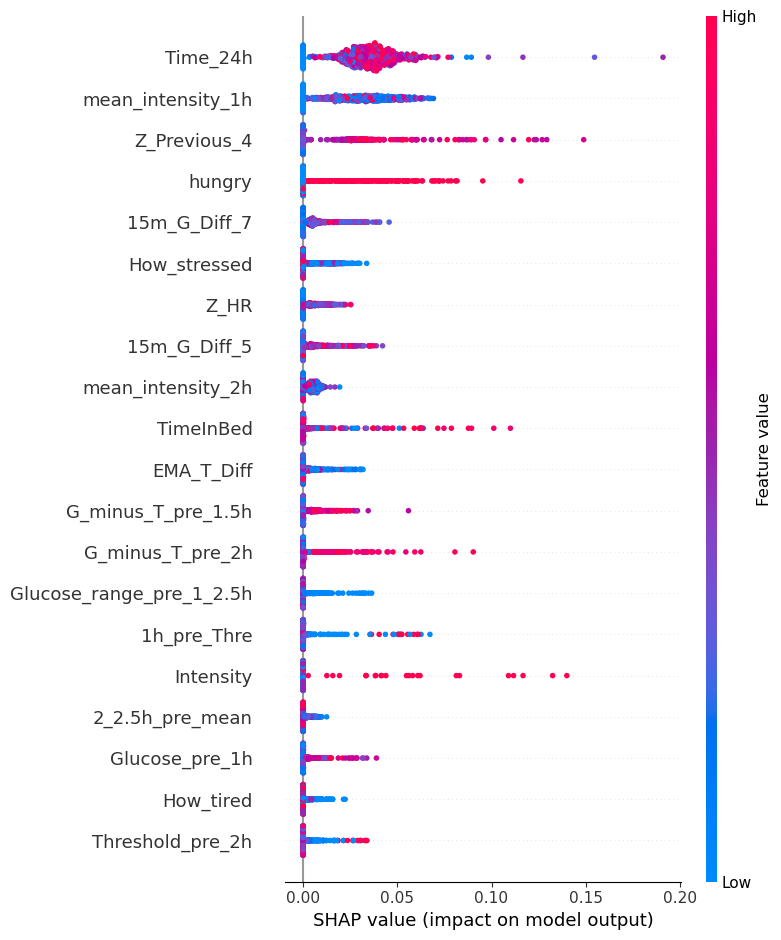

In [43]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) SHAP 값 (class=1)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_alerts_mod)
shap_pos = shap_values[1]

# 2) 음수 SHAP → 0으로 클리핑
shap_pos_clipped = np.where(shap_pos > 0, shap_pos, 0)

# 3) hungry 컬럼을 색상 기준으로 지정
#    hungry가 binary니까 그대로 color parameter로 전달
hungry_values = X_alerts_mod["hungry"].astype(int).values

# 4) summary_plot (양수만)
shap.summary_plot(
    shap_pos_clipped,
    X_alerts_mod,
    feature_names=FEATURES,
    show=True,
    color=hungry_values   # shap의 color_values 인자로 binary 넘겨줌
)

plt.show()


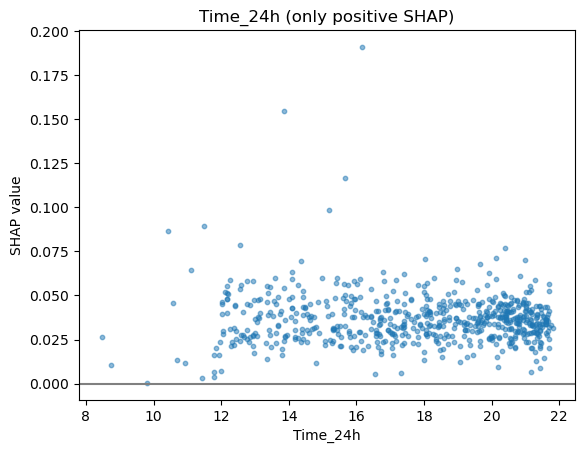

In [45]:
import matplotlib.pyplot as plt

feat = "Time_24h"
idx = FEATURES.index(feat)
vals = X_alerts[feat].values
shaps = shap_pos[:, idx]

mask = shaps > 0
plt.scatter(vals[mask], shaps[mask], alpha=0.5, s=10)
plt.axhline(0, color="gray")
plt.xlabel(feat)
plt.ylabel("SHAP value")
plt.title(f"{feat} (only positive SHAP)")
plt.show()


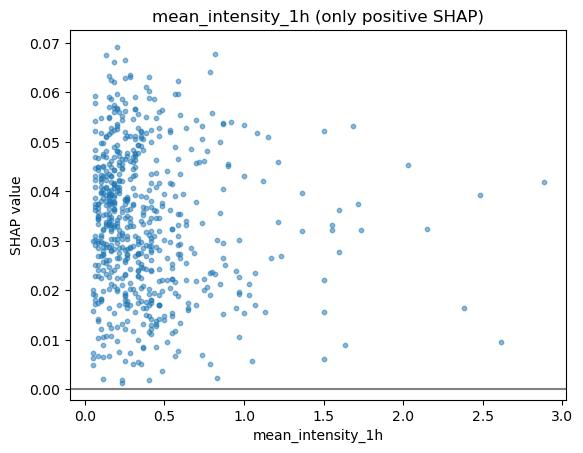

In [47]:
import matplotlib.pyplot as plt

feat = "mean_intensity_1h"
idx = FEATURES.index(feat)
vals = X_alerts[feat].values
shaps = shap_pos[:, idx]

mask = shaps > 0
plt.scatter(vals[mask], shaps[mask], alpha=0.5, s=10)
plt.axhline(0, color="gray")
plt.xlabel(feat)
plt.ylabel("SHAP value")
plt.title(f"{feat} (only positive SHAP)")
plt.show()


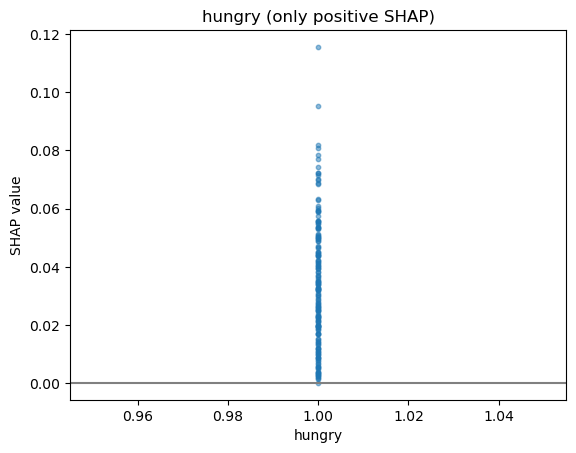

In [49]:
import matplotlib.pyplot as plt

feat = "hungry"
idx = FEATURES.index(feat)
vals = X_alerts[feat].values
shaps = shap_pos[:, idx]

mask = shaps > 0
plt.scatter(vals[mask], shaps[mask], alpha=0.5, s=10)
plt.axhline(0, color="gray")
plt.xlabel(feat)
plt.ylabel("SHAP value")
plt.title(f"{feat} (only positive SHAP)")
plt.show()


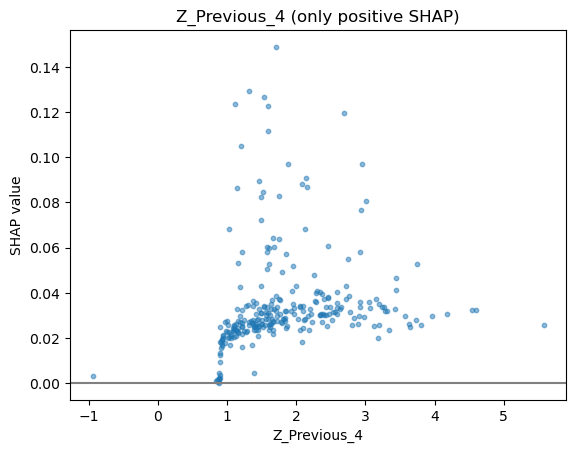

In [51]:
import matplotlib.pyplot as plt

feat = "Z_Previous_4"
idx = FEATURES.index(feat)
vals = X_alerts[feat].values
shaps = shap_pos[:, idx]

mask = shaps > 0
plt.scatter(vals[mask], shaps[mask], alpha=0.5, s=10)
plt.axhline(0, color="gray")
plt.xlabel(feat)
plt.ylabel("SHAP value")
plt.title(f"{feat} (only positive SHAP)")
plt.show()


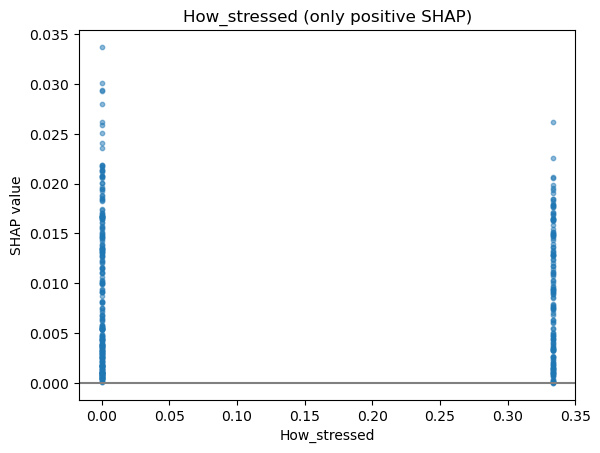

In [53]:
import matplotlib.pyplot as plt

feat = "How_stressed"
idx = FEATURES.index(feat)
vals = X_alerts[feat].values
shaps = shap_pos[:, idx]

mask = shaps > 0
plt.scatter(vals[mask], shaps[mask], alpha=0.5, s=10)
plt.axhline(0, color="gray")
plt.xlabel(feat)
plt.ylabel("SHAP value")
plt.title(f"{feat} (only positive SHAP)")
plt.show()


# Top 3 frequency

In [61]:
from collections import Counter
import numpy as np

# 1) 변수별 top3 등장 횟수 카운트
feat_counter = Counter()

for i in range(shap_pos_clipped.shape[0]):
    row_vals = shap_pos_clipped[i, :]
    top_idx = np.argsort(-row_vals)[:3]
    for j in top_idx:
        feat_counter[FEATURES[j]] += 1

# 2) DataFrame으로 정리
feat_counts = pd.DataFrame.from_dict(feat_counter, orient="index", columns=["Top3_count"])
feat_counts["Top3_percent"] = feat_counts["Top3_count"] / shap_pos_clipped.shape[0]  # 전체 692개 대비 비율
feat_counts_sorted = feat_counts.sort_values("Top3_count", ascending=False)

# 3) 출력 (상위 15개)
print("\n=== Top features by Top3 frequency (692 alerts) ===")
print(feat_counts_sorted.head(15))



=== Top features by Top3 frequency (692 alerts) ===
                    Top3_count  Top3_percent
Time_24h                   596      0.861272
mean_intensity_1h          554      0.800578
Z_Previous_4               226      0.326590
hungry                     135      0.195087
15m_G_Diff_7                72      0.104046
Z_HR                        68      0.098266
How_stressed                52      0.075145
15m_G_Diff_5                51      0.073699
G_minus_T_pre_2h            45      0.065029
TimeInBed                   39      0.056358
EMA_T_Diff                  38      0.054913
G_minus_T_pre_1.5h          34      0.049133
mean_intensity_2h           30      0.043353
1h_pre_Thre                 25      0.036127
Intensity                   19      0.027457


# Find Top 3 combination

In [58]:
from collections import Counter
import numpy as np

# 1) 각 샘플별로 SHAP top3 feature index 추출
top3_combos = []
for i in range(shap_pos_clipped.shape[0]):
    # row별 SHAP 값
    row_vals = shap_pos_clipped[i, :]
    
    # top3 index (값 큰 순서)
    top_idx = np.argsort(-row_vals)[:3]
    
    # feature 이름으로 변환
    top_feats = [FEATURES[j] for j in top_idx]
    
    # 조합을 tuple로 (정렬해서 순서 무관하게)
    combo = tuple(sorted(top_feats))
    top3_combos.append(combo)

# 2) 빈도수 집계
combo_counts = Counter(top3_combos)

# 3) 상위 3개 조합 출력
print("\n=== Top 3 most frequent top3-feature combinations (692 alerts) ===")
for combo, count in combo_counts.most_common(10):
    print(f"{combo}: {count} times ({count/692:.2%})")



=== Top 3 most frequent top3-feature combinations (692 alerts) ===
('Time_24h', 'hungry', 'mean_intensity_1h'): 119 times (17.20%)
('Time_24h', 'Z_Previous_4', 'mean_intensity_1h'): 102 times (14.74%)
('Time_24h', 'Z_HR', 'mean_intensity_1h'): 47 times (6.79%)
('15m_G_Diff_7', 'Time_24h', 'mean_intensity_1h'): 42 times (6.07%)
('How_stressed', 'Time_24h', 'mean_intensity_1h'): 41 times (5.92%)
('15m_G_Diff_5', 'Time_24h', 'mean_intensity_1h'): 26 times (3.76%)
('EMA_T_Diff', 'Time_24h', 'mean_intensity_1h'): 24 times (3.47%)
('Time_24h', 'mean_intensity_1h', 'mean_intensity_2h'): 24 times (3.47%)
('G_minus_T_pre_2h', 'Time_24h', 'Z_Previous_4'): 22 times (3.18%)
('Intensity', 'TimeInBed', 'mean_intensity_1h'): 19 times (2.75%)


In [383]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shap

def force_row_color(ax, row_label: str, color="red", atol=0.25):
    """
    After a SHAP summary_plot, recolor only the points on the row with label `row_label`.
    Works even when that feature is constant (normally drawn gray).
    """
    # 1) 현재 축의 ytick 라벨과 위치를 읽어 라벨→y좌표 매핑
    labels = [t.get_text() for t in ax.get_yticklabels()]
    ticks  = ax.get_yticks()
    mapping = {lab: pos for lab, pos in zip(labels, ticks)}
    if row_label not in mapping:
        return False  # 해당 라벨 없음
    y_target = mapping[row_label]

    rgba = matplotlib.colors.to_rgba(color)

    # 2) plot에 존재하는 모든 PathCollection(점모음)을 순회하며
    #    y좌표가 해당 줄인 점들만 색 교체
    changed = False
    for coll in ax.collections:
        offsets = coll.get_offsets()
        if offsets is None or len(offsets) == 0:
            continue

        # y가 row 위치와 같은 점들만 선택 (jitter 감안해 허용오차 사용)
        mask = np.isclose(offsets[:, 1], y_target, atol=atol)
        if not mask.any():
            continue

        # facecolors 길이가 1이면(단일색) per-point로 복제
        fc = coll.get_facecolors()
        if fc is None or len(fc) == 0:
            continue
        if fc.shape[0] == 1 and offsets.shape[0] > 1:
            fc = np.tile(fc, (offsets.shape[0], 1))

        fc[mask] = rgba
        coll.set_facecolors(fc)

        # edgecolor도 맞춰서 바꾸면 더 또렷함
        ec = coll.get_edgecolors()
        if ec is not None and ec.shape[0] > 0:
            if ec.shape[0] == 1 and offsets.shape[0] > 1:
                ec = np.tile(ec, (offsets.shape[0], 1))
            ec[mask] = rgba
            coll.set_edgecolors(ec)

        changed = True

    return changed


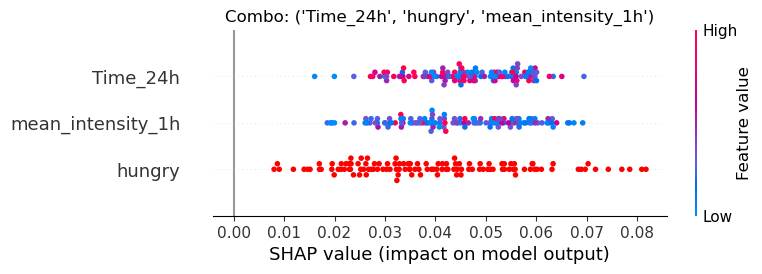

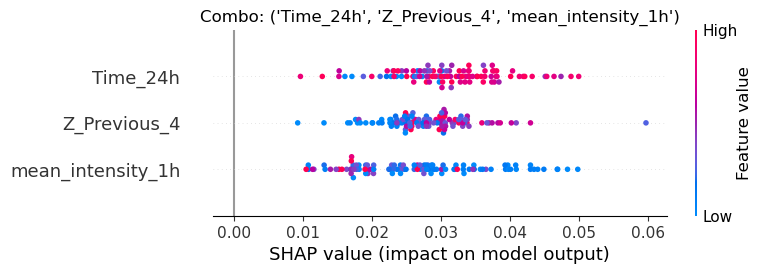

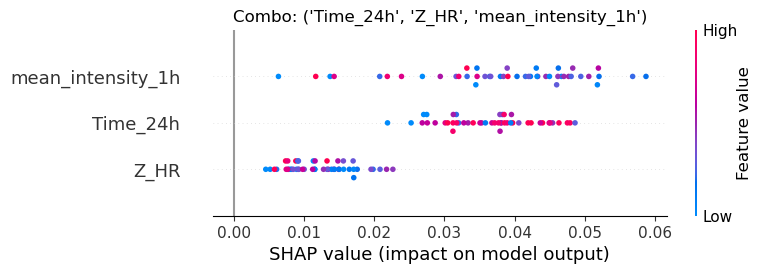

In [385]:
# 상위 3개 조합
top3_most_common = [combo for combo, _ in combo_counts.most_common(3)]

for combo in top3_most_common:
    idxs = [i for i, c in enumerate(top3_combos) if c == combo]
    shap_subset = shap_pos_clipped[idxs, :]
    X_subset = X_alerts.iloc[idxs]

    combo_idx  = [FEATURES.index(f) for f in combo]
    shap_combo = shap_subset[:, combo_idx]
    X_combo    = X_subset[list(combo)].copy()

    # summary plot 먼저 그림 (정렬 여부 상관 없음; 라벨 기반으로 찾을 것)
    shap.summary_plot(
        shap_combo,
        X_combo,
        feature_names=list(combo),
        plot_type="dot",
        max_display=len(combo),
        show=False
    )

    # hungry가 포함되면 후처리로 'hungry' 줄만 빨강으로 교체
    if "hungry" in X_combo.columns:
        _ = force_row_color(plt.gca(), "hungry", color="red", atol=0.25)

    plt.title(f"Combo: {combo}")
    plt.show()


# Z_Previous_4(1 hour ago glucose): Actual Glucose Trend

In [93]:
# Timestamp 형식을 통일하고 초 단위까지만 맞추기
df["Timestamp"] = pd.to_datetime(df["Timestamp"]).dt.round("min")
alerts_S1_120["ts"] = pd.to_datetime(alerts_S1_120["ts"]).dt.round("min")

# 이제 merge
tp_alerts_idx = df.reset_index().merge(
    alerts_S1_120.query("success_120m == 1")[["StudyID", "ts"]],
    left_on=["StudyID", "Timestamp"],
    right_on=["StudyID", "ts"],
    how="inner"
)[["index", "StudyID", "Timestamp"]]

print(f"매칭된 TP alerts: {len(tp_alerts_idx)}")


매칭된 TP alerts: 222


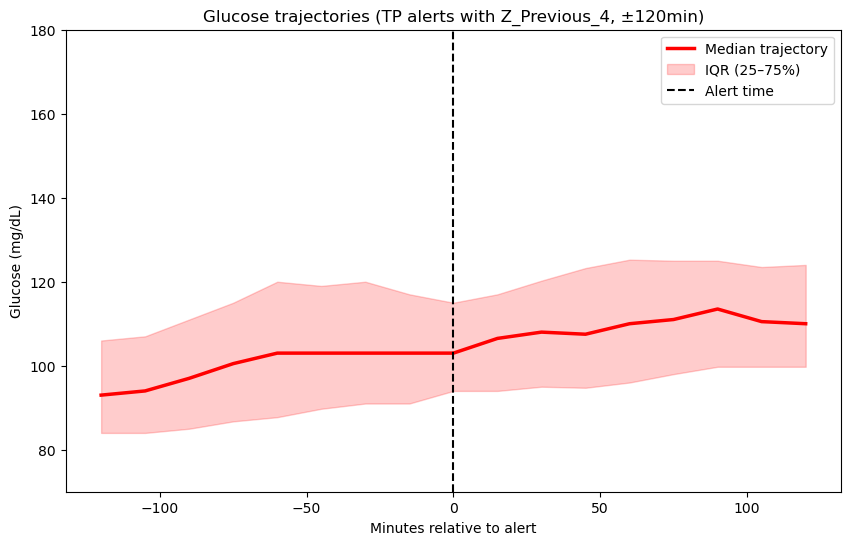

In [387]:
# TP 혈당 Z_previous_4 그래프 다시그리기 

import matplotlib.pyplot as plt
import numpy as np

# 1) TP 알림 인덱스/시간 확보
tp_alerts_idx = df.reset_index().merge(
    alerts_S1_120.query("success_120m == 1")[["StudyID", "ts"]],
    left_on=["StudyID", "Timestamp"],
    right_on=["StudyID", "ts"],
    how="inner"
)[["index", "StudyID", "Timestamp"]]


# 2) 궤적 추출 (±2시간 → 15분 단위 → 16 포인트 + 현재 = 17포인트)
time_points = np.arange(-120, 121, 15)  # [-120, -105, ..., 0, ..., 105, 120]
trajectories = []

for _, row in tp_alerts_idx.iterrows():
    sid, t0 = row["StudyID"], row["Timestamp"]
    g = df[df["StudyID"] == sid].sort_values("Timestamp").reset_index(drop=True)

    if t0 not in g["Timestamp"].values:
        continue
    idx0 = g[g["Timestamp"] == t0].index[0]

    # 전후 8포인트 확보 (±120분)
    start, end = idx0 - 8, idx0 + 8
    if start < 0 or end >= len(g):
        continue  # 범위 벗어나면 스킵

    traj = g.loc[start:end, "Glucose"].to_numpy()
    if len(traj) == len(time_points):
        trajectories.append(traj)

trajectories = np.array(trajectories, dtype=float)

# 3) 중앙값 곡선
median_traj = np.nanmedian(trajectories, axis=0)

# 4) 시각화
import numpy as np
import matplotlib.pyplot as plt

trajectories_arr = np.vstack(trajectories)  # (n_samples, n_timepoints)

median_curve = np.median(trajectories_arr, axis=0)
q25 = np.percentile(trajectories_arr, 25, axis=0)
q75 = np.percentile(trajectories_arr, 75, axis=0)

plt.figure(figsize=(10,6))
plt.plot(time_points, median_curve, color="red", linewidth=2.5, label="Median trajectory")
plt.fill_between(time_points, q25, q75, color="red", alpha=0.2, label="IQR (25–75%)")
plt.axvline(0, color="black", linestyle="--", label="Alert time")

plt.xlabel("Minutes relative to alert")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose trajectories (TP alerts with Z_Previous_4, ±120min)")
plt.ylim(70, 180)
plt.legend()
plt.show()

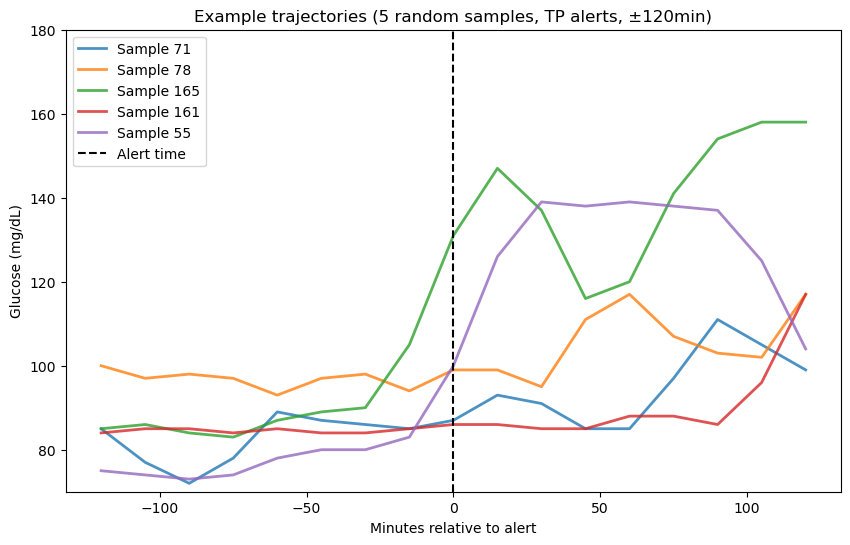

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# 실행할 때마다 다른 랜덤 샘플 5개 선택
sample_idx = np.random.choice(len(trajectories), size=5, replace=False)

plt.figure(figsize=(10,6))

# 샘플 5개 곡선
for i in sample_idx:
    plt.plot(time_points, trajectories[i], linewidth=2, alpha=0.8, label=f"Sample {i}")

# 알림 시점
plt.axvline(0, color="black", linestyle="--", label="Alert time")

plt.xlabel("Minutes relative to alert")
plt.ylabel("Glucose (mg/dL)")
plt.title("Example trajectories (5 random samples, TP alerts, ±120min)")
plt.ylim(70, 180)
plt.legend()
plt.show()




# SHAP value as a varialbes

In [389]:
import pandas as pd

# shap_values[1]은 (n_samples, n_features)
shap_matrix = pd.DataFrame(
    shap_values[1],
    columns=[f"SHAP_{f}" for f in FEATURES],
    index=alerts_with_X.index
)

# 원본 데이터와 합치고 싶다면
alerts_with_shap = pd.concat([alerts_with_X.reset_index(drop=True), shap_matrix.reset_index(drop=True)], axis=1)


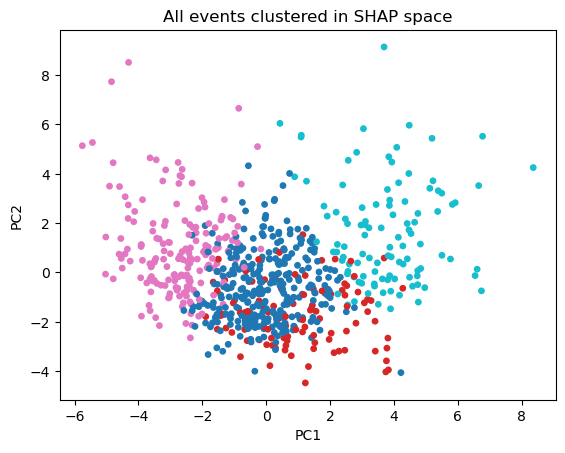

In [391]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Standardize + PCA
Z = StandardScaler().fit_transform(shap_matrix)
Zp = PCA(n_components=10, random_state=0).fit_transform(Z)

# KMeans clustering
k = 4   # 군집 수는 silhouette score로 고를 수 있음
km = KMeans(n_clusters=k, random_state=0, n_init=20)
labels_all = km.fit_predict(Zp)

shap_matrix["cluster_all"] = labels_all
alerts_with_shap["cluster_all"] = labels_all

# 시각화
plt.scatter(Zp[:,0], Zp[:,1], c=labels_all, cmap="tab10", s=15)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("All events clustered in SHAP space")
plt.show()


In [423]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# 모델 예측
y_pred = model.predict(X_alerts_mod)
alerts_with_X["y_pred"] = y_pred

# === 3단계: TP subset 클러스터링 ===
# TP 정의 (예시: success_120m == 1)
TP_idx = (alerts_S1_120["success_120m"] == 1)

# SHAP 행렬에서 TP만 추출
shap_tp = shap_matrix.loc[TP_idx, shap_matrix.columns.drop("cluster_all")].copy()

# 스케일링 + PCA
Z_tp = StandardScaler().fit_transform(shap_tp)
Zp_tp = PCA(n_components=10, random_state=0).fit_transform(Z_tp)

# 클러스터링 (예시: k=3)
km_tp = KMeans(n_clusters=4, random_state=0, n_init=20)
labels_tp = km_tp.fit_predict(Zp_tp)

# cluster_tp 레이블 추가
shap_tp["cluster_tp"] = labels_tp

# === 4단계: 클러스터별 평균 SHAP 프로파일 ===
mean_profiles_tp = shap_tp.groupby("cluster_tp").mean().T

for c in mean_profiles_tp.columns:
    col = mean_profiles_tp[c]
    top_feats = col.abs().sort_values(ascending=False).head(5).index
    print(f"\n=== TP Cluster {c} | Top 5 features ===")
    print(col.loc[top_feats].sort_values(ascending=False))



=== TP Cluster 0 | Top 5 features ===
SHAP_Time_24h             0.032834
SHAP_mean_intensity_1h    0.021041
SHAP_2_2.5h_pre_std      -0.013816
SHAP_hungry              -0.048323
SHAP_Intensity           -0.061941
Name: 0, dtype: float64

=== TP Cluster 1 | Top 5 features ===
SHAP_Time_24h             0.033910
SHAP_mean_intensity_1h    0.032152
SHAP_1.5_2h_pre_std      -0.015987
SHAP_hungry              -0.031893
SHAP_Intensity           -0.065015
Name: 1, dtype: float64

=== TP Cluster 2 | Top 5 features ===
SHAP_Z_Previous_4        0.046534
SHAP_Time_24h            0.027460
SHAP_G_minus_T_pre_2h    0.023642
SHAP_hungry             -0.050235
SHAP_Intensity          -0.072724
Name: 2, dtype: float64

=== TP Cluster 3 | Top 5 features ===
SHAP_Time_24h             0.053313
SHAP_mean_intensity_1h    0.040418
SHAP_hungry               0.028789
SHAP_2_2.5h_pre_std      -0.024723
SHAP_Intensity           -0.052825
Name: 3, dtype: float64


In [415]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cluster_distributions(df, var, cluster_col="cluster_all", mask_tp=None, discrete=False):
    """
    df: 데이터프레임 (변수 + cluster 라벨 포함)
    var: 그릴 변수 이름 (예: "Time_24h")
    cluster_col: 클러스터 라벨 컬럼
    mask_tp: TP subset 마스크 (선택)
    discrete: True면 이산형 변수 → histplot, False면 연속형 → kdeplot
    """
    palette = sns.color_palette("tab10", df[cluster_col].nunique())

    # 전체
    plt.figure(figsize=(7,5))
    if discrete:
        sns.histplot(data=df, x=var, hue=cluster_col, multiple="dodge",
                     shrink=0.7, palette=palette)
    else:
        sns.kdeplot(data=df, x=var, hue=cluster_col, fill=True, common_norm=False,
                    alpha=0.4, palette=palette)
    plt.title(f"All Alerts - {var} by Cluster (k={df[cluster_col].nunique()})")
    plt.show()

    # TP subset
    if mask_tp is not None:
        plt.figure(figsize=(7,5))
        if discrete:
            sns.histplot(data=df[mask_tp], x=var, hue=cluster_col, multiple="dodge",
                         shrink=0.7, palette=palette)
        else:
            sns.kdeplot(data=df[mask_tp], x=var, hue=cluster_col, fill=True, common_norm=False,
                        alpha=0.4, palette=palette)
        plt.title(f"TP Alerts - {var} by Cluster (k={df[cluster_col].nunique()})")
        plt.show()


TP count (expect 222): 222


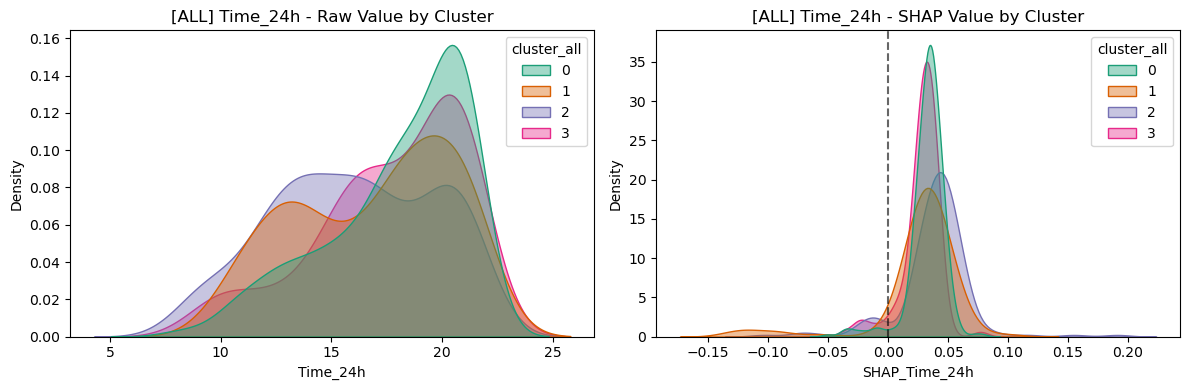

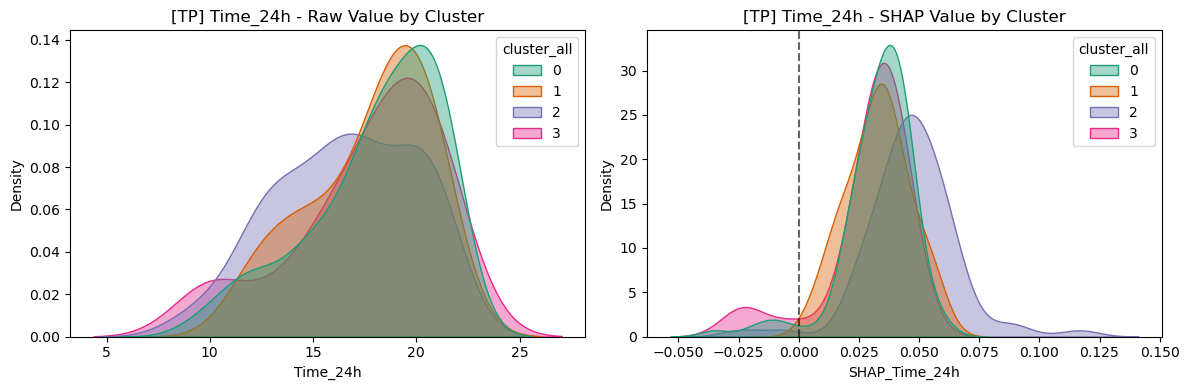

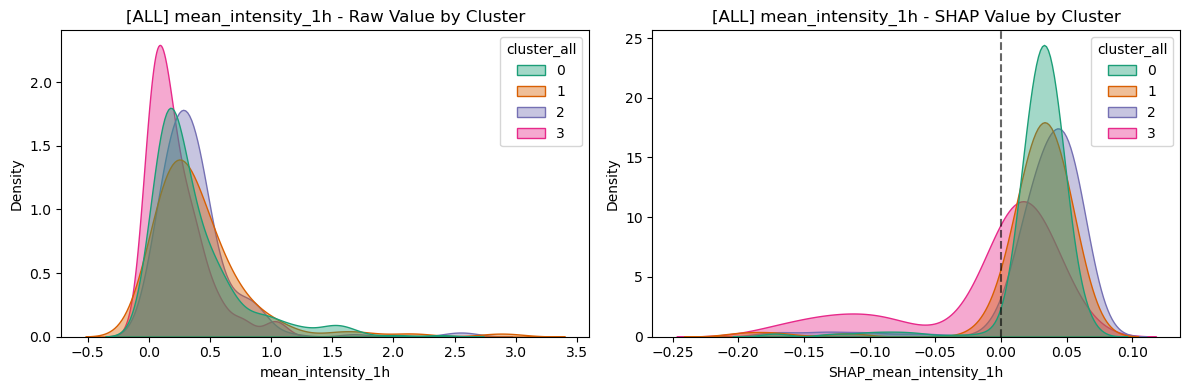

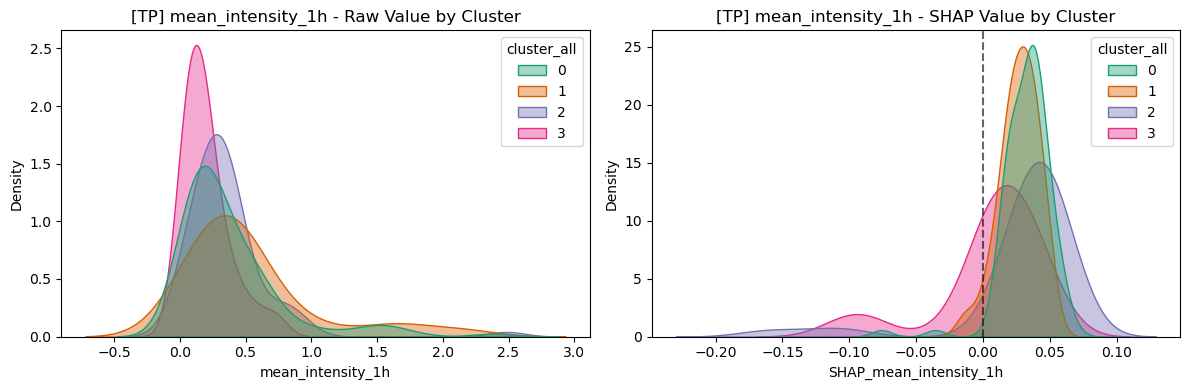

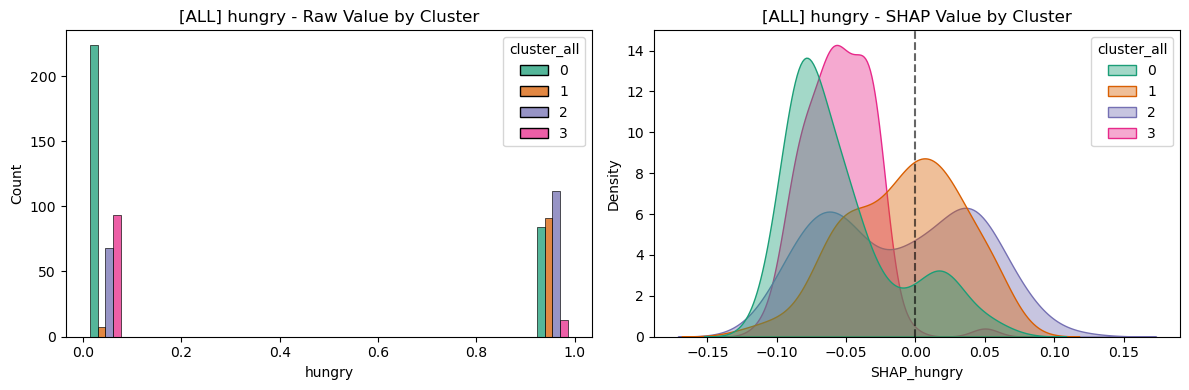

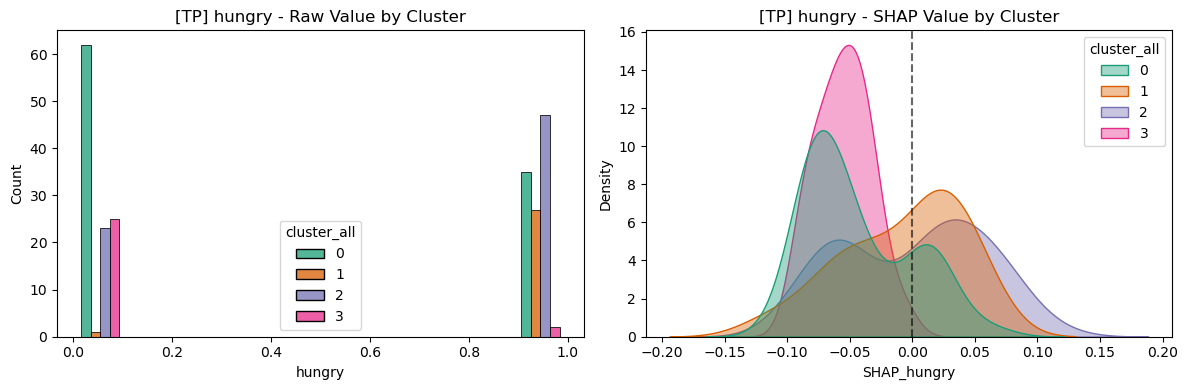

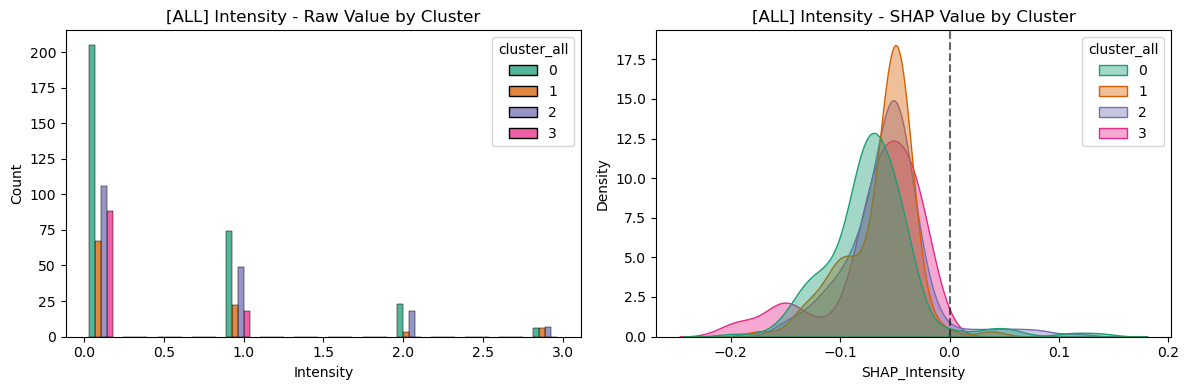

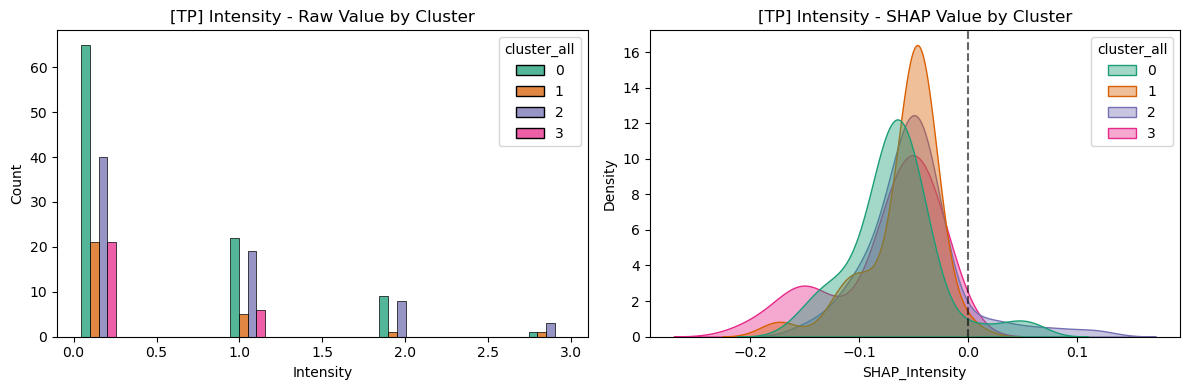


=== Cluster counts (ALL) ===
Cluster 0: 308 alerts (44.5%)
Cluster 1: 98 alerts (14.2%)
Cluster 2: 180 alerts (26.0%)
Cluster 3: 106 alerts (15.3%)

=== Cluster counts (TP only) ===
Cluster 0: 97 alerts (43.7%)
Cluster 1: 28 alerts (12.6%)
Cluster 2: 70 alerts (31.5%)
Cluster 3: 27 alerts (12.2%)

Total events: 692, TP subset: 222


In [421]:
# =========================
# 0) Imports & 준비
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# -------------------------
# 1) SHAP 행렬(signed) 생성
# -------------------------
# shap_values[1] : (n_samples, n_features)  ← 이미 계산되어 있다고 가정
shap_matrix = pd.DataFrame(
    shap_values[1],
    columns=[f"SHAP_{f}" for f in FEATURES]
)

# alerts_with_X : 원 변수들이 들어있는 DF (이미 보유)
# alerts_S1_120 : success_120m 포함 DF (이미 보유)

# 인덱스 맞추기 (중요!)
shap_matrix = shap_matrix.reset_index(drop=True)
alerts_with_X = alerts_with_X.reset_index(drop=True)
alerts_S1_120 = alerts_S1_120.reset_index(drop=True)

# -------------------------
# 2) 전체 이벤트 클러스터 라벨 만들기 (없으면 생성)
# -------------------------
if "cluster_all" not in shap_matrix.columns:
    Z = StandardScaler().fit_transform(shap_matrix.values)
    Zp = PCA(n_components=min(10, shap_matrix.shape[1]), random_state=0).fit_transform(Z)

    k_all = 4
    km_all = KMeans(n_clusters=k_all, random_state=0, n_init=20)
    labels_all = km_all.fit_predict(Zp)

    shap_matrix["cluster_all"] = labels_all
    # 원본 변수 DF에도 같은 라벨 부여 (정렬 일치)
    alerts_with_X["cluster_all"] = labels_all
else:
    # 이미 있다면 원본 DF에도 싱크
    if "cluster_all" not in alerts_with_X.columns:
        alerts_with_X["cluster_all"] = shap_matrix["cluster_all"].values

# 시각화를 위한 일관 팔레트/라벨 순서
clusters_all_list = sorted(shap_matrix["cluster_all"].unique())
palette_fixed = sns.color_palette("Dark2", len(clusters_all_list))

# -------------------------
# 3) TP 마스크 (성공=1)
# -------------------------
tp_mask = (alerts_S1_120["success_120m"].values == 1)
print("TP count (expect 222):", int(tp_mask.sum()))
assert len(tp_mask) == len(shap_matrix) == len(alerts_with_X), "Row alignment mismatch!"

# -------------------------
# 4) 플로팅 함수
#    (클러스터별 원값 분포 vs SHAP 분포)
# -------------------------
def plot_cluster_shap_and_value(df_raw_all, df_shap_all,
                                features, cluster_col="cluster_all",
                                clusters_order=None, palette=None,
                                tp_mask=None):
    """
    df_raw_all : 원 변수(예: Time_24h, hungry, ...) + cluster_all 포함 DF
    df_shap_all: SHAP_* 열 + cluster_all 포함 DF
    features   : ["Time_24h","mean_intensity_1h","hungry","Intensity"] 등
    clusters_order : [0,1,2,3] 처럼 고정된 표시 순서
    palette    : seaborn 팔레트 (len = #clusters)
    tp_mask    : TP subset boolean mask (len == n_samples). None이면 ALL만 그림
    """
    if clusters_order is None:
        clusters_order = sorted(df_raw_all[cluster_col].unique())
    if palette is None:
        palette = sns.color_palette("Dark2", len(clusters_order))

    # ALL(전체)용 DF
    df_raw_ALL  = df_raw_all.copy()
    df_shap_ALL = df_shap_all.copy()

    # TP subset DF (옵션)
    if tp_mask is not None:
        df_raw_TP  = df_raw_all.loc[tp_mask].copy()
        df_shap_TP = df_shap_all.loc[tp_mask].copy()

    for feat in features:
        # 1) 원값 분포 (ALL)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        if df_raw_ALL[feat].nunique() <= 5:  # hungry 같은 이산형
            sns.histplot(data=df_raw_ALL, x=feat, hue=cluster_col,
                         multiple="dodge", shrink=0.7,
                         hue_order=clusters_order, palette=palette)
        else:
            sns.kdeplot(data=df_raw_ALL, x=feat, hue=cluster_col,
                        fill=True, common_norm=False, alpha=0.4,
                        hue_order=clusters_order, palette=palette)
        plt.title(f"[ALL] {feat} - Raw Value by Cluster")

        # 2) SHAP 분포 (ALL)
        plt.subplot(1,2,2)
        shap_col = f"SHAP_{feat}" if f"SHAP_{feat}" in df_shap_ALL.columns else feat
        sns.kdeplot(data=df_shap_ALL, x=shap_col, hue=cluster_col,
                    fill=True, common_norm=False, alpha=0.4,
                    hue_order=clusters_order, palette=palette)
        plt.axvline(0, color="k", linestyle="--", alpha=0.6)
        plt.title(f"[ALL] {feat} - SHAP Value by Cluster")
        plt.tight_layout()
        plt.show()

        # --- TP subset이 있으면 동일 구도로 추가 ---
        if tp_mask is not None:
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            if df_raw_TP[feat].nunique() <= 5:
                sns.histplot(data=df_raw_TP, x=feat, hue=cluster_col,
                             multiple="dodge", shrink=0.7,
                             hue_order=clusters_order, palette=palette)
            else:
                sns.kdeplot(data=df_raw_TP, x=feat, hue=cluster_col,
                            fill=True, common_norm=False, alpha=0.4,
                            hue_order=clusters_order, palette=palette)
            plt.title(f"[TP] {feat} - Raw Value by Cluster")

            plt.subplot(1,2,2)
            sns.kdeplot(data=df_shap_TP, x=shap_col, hue=cluster_col,
                        fill=True, common_norm=False, alpha=0.4,
                        hue_order=clusters_order, palette=palette)
            plt.axvline(0, color="k", linestyle="--", alpha=0.6)
            plt.title(f"[TP] {feat} - SHAP Value by Cluster")
            plt.tight_layout()
            plt.show()

# -------------------------
# 5) 실행: 4개 변수 대상
# -------------------------
features_to_plot = ["Time_24h", "mean_intensity_1h", "hungry", "Intensity"]

# shap DF에 cluster_all을 안전하게 부여 (중복/충돌 방지)
shap_with_cluster = shap_matrix.copy()
if "cluster_all" not in shap_with_cluster.columns:
    shap_with_cluster["cluster_all"] = alerts_with_X["cluster_all"].values

# 원값 DF(=alerts_with_X)에도 반드시 cluster_all 있어야 함
raw_with_cluster = alerts_with_X.copy()
assert "cluster_all" in raw_with_cluster.columns, "cluster_all 라벨이 원본 DF에 없습니다."

# 전체(ALL) + TP 둘 다 그리기
plot_cluster_shap_and_value(
    df_raw_all=raw_with_cluster,
    df_shap_all=shap_with_cluster,
    features=features_to_plot,
    cluster_col="cluster_all",
    clusters_order=clusters_all_list,
    palette=palette_fixed,
    tp_mask=tp_mask  # TP 분포도 함께 그림
)

# -------------------------
# 6) (선택) 클러스터 개수 요약
# -------------------------
counts_all = shap_with_cluster["cluster_all"].value_counts().sort_index()
counts_tp  = shap_with_cluster.loc[tp_mask, "cluster_all"].value_counts().sort_index()

print("\n=== Cluster counts (ALL) ===")
for c, cnt in counts_all.items():
    print(f"Cluster {c}: {cnt} alerts ({cnt/len(shap_with_cluster):.1%})")

print("\n=== Cluster counts (TP only) ===")
for c, cnt in counts_tp.items():
    print(f"Cluster {c}: {cnt} alerts ({cnt/len(shap_with_cluster.loc[tp_mask]):.1%})")

print(f"\nTotal events: {len(shap_with_cluster)}, TP subset: {int(tp_mask.sum())}")
